In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
os.chdir('./4-3/')
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body
import yolo_utils

Using TensorFlow backend.


In [42]:
K.clear_session()
K.set_image_data_format('channels_last')

In [44]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, prob_threshold=0.6):
    
    '''
    input:
        box_confidence - tensor, (19,19,5,1), [...,:]: pc
        boxes - tensor, (19,19,5,4), [...,:]: (bx, by, bh, bw)
        box_class_probs - tensor, (19,19,5,80), [...,:]: (c1,c2...c80)
        prob_threshold - float, ~ [0,1)
    output:
        scores - tensor, (None,), probs
        boxes - tensor, (None,4), (bx, by, bh, bw)
        classes - tensor, (None,), indices ~ [0, 80)
    '''

    box_scores = box_confidence * box_class_probs   # (19,19,5,80)
    box_classes = K.argmax(box_scores, axis=-1) # (19,19,5)
    box_classes_scores = K.max(box_scores, axis=-1) # (19,19,5)

    filter_mask = (box_classes_scores >= prob_threshold)    # (19,19,5)

    scores = tf.boolean_mask(box_classes_scores, filter_mask)   # (None,)
    boxes = tf.boolean_mask(boxes, filter_mask) # (None,4)
    classes = tf.boolean_mask(box_classes, filter_mask) # (None,)

    return scores, boxes, classes

In [45]:
def compute_iou(box1, box2):

    '''
    input:
        box1 - (x1,y1,x2,y2), corners
        box2 - (x1,y1,x2,y2), corners
    output:
        iou - float
    '''

    x1_inner = np.maximum(box1[0], box2[0])
    y1_inner = np.maximum(box1[1], box2[1])
    x2_inner = np.minimum(box1[2], box2[2])
    y2_inner = np.minimum(box1[3], box2[3])

    inner_area = (x2_inner - x1_inner) * (y2_inner - y1_inner)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inner_area

    iou = inner_area / union_area

    return iou

In [48]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes=10, iou_threshold=0.5):

    '''
    input:
        scores - output of yolo_filter_boxes(), (None,)
        boxes - output of yolo_filter_boxes(), (None,4)
        classes - output of yoli_filter_boxes(), (None,)
        max_boxes - int, maximum numbers of boxes to keep from top
        iou_threshold - float, ~ [0,1)
    output:
        scores - tensor, (None,), probs
        boxes - tensor, (None,4), (bx, by, bh, bw)
        classes - tensor, (None,), indices ~ [0, 80)
    '''

    max_boxes_tensor = K.variable(max_boxes, 'int32')
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))

    indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold=iou_threshold)

    scores = K.gather(scores, indices)  # scores[indices], retrieve method in keras
    boxes = K.gather(boxes, indices)
    classes = K.gather(classes, indices)
    
    return scores, boxes, classes

In [50]:
def yolo_eval(yolo_outputs, image_shape=(720., 1280.), max_boxes=10, prob_threshold=0.6, iou_threshold=0.5):

    '''
    input:
        yolo_outputs - output of yolo_head(), (box_confidence, box_xy, box_wh, box_class_probs)
        image_shape - (float, float)
        max_boxes - output of yoli_filter_boxes(), (None,)
        prob_threshold - float, ~ [0,1)
        iou_threshold - float, ~ [0,1)
    output:
        scores - tensor, (None,), probs
        boxes - tensor, (None,4), (bx, by, bh, bw)
        classes - tensor, (None,), indices ~ [0, 80)
    '''

    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, prob_threshold=prob_threshold)   # filter probability

    boxes = yolo_utils.scale_boxes(boxes, image_shape)  # from in(608,608) to in(720,1280)

    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes=max_boxes, iou_threshold=iou_threshold) # no max suppression (NMS)

    return scores, boxes, classes

In [51]:
sess = K.get_session()

In [52]:
class_names = yolo_utils.read_classes('./model_data/coco_classes.txt')
anchors = yolo_utils.read_anchors('./model_data/yolo_anchors.txt')
image_shape = (720., 1280.)

In [53]:
yolo_model = load_model('./model_data/yolov2.h5')



C:\Users\Administrator\Anaconda3\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [54]:
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [58]:
# add a graph node to transform (None,19,19,5,85) to ((None,19,19,5,1), \
# (None,19,19,5,2), (None,19,19,5,2), (None,19,19,5,80))
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [60]:
# add graph nodes to compute yolo_eval()
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape=image_shape, max_boxes=10, prob_threshold=0.6, iou_threshold=0.5)
# finish the compute graph

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [66]:
def predict(sess, image_file, is_show_info=True, is_plot=True):

    '''
    input:
        sess - TensorFlow Session
        image_file - image file name
    output:
        out_scores - tensor, (None,), probs
        out_boxes - tensor, (None,4), (bx, by, bh, bw)
        out_classes - tensor, (None,), indices ~ [0, 80)
    '''

    image, image_data = yolo_utils.preprocess_image(f'./images/{image_file}', (608, 608))

    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})

    if is_show_info:
        print(f'在{image_file}中找到了{len(out_boxes)}个锚框.')

    colors = yolo_utils.generate_colors(class_names)
    yolo_utils.draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    image.save(f'./out/{image_file}', quality=100)

    if is_plot:
        out_image = scipy.misc.imread(f'./out/{image_file}')    # ndarray
        plt.imshow(out_image)

    return  out_scores, out_boxes, out_classes

在test.jpg中找到了7个锚框.
car 0.60 (925, 285) (1045, 374)
car 0.66 (706, 279) (786, 350)
bus 0.67 (5, 266) (220, 407)
car 0.70 (947, 324) (1280, 705)
car 0.74 (159, 303) (346, 440)
car 0.80 (761, 282) (942, 412)
car 0.89 (367, 300) (745, 648)
C:\Users\Administrator\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


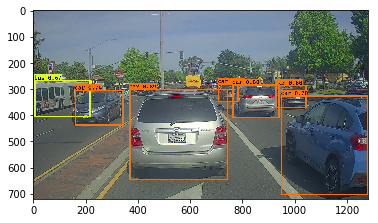

In [67]:
out_scores, out_boxes, out_classes = predict(sess, 'test.jpg', is_show_info=True, is_plot=True)

In [72]:
for i in range(1, 121):
    image_file = str(i).zfill(4) + '.jpg'
    print(f'正在处理{image_file}')
    out_scores, out_boxes, out_classes = predict(sess, image_file, is_show_info=False, is_plot=False)
    
print('=== finish! ===')

正在处理0001.jpg
正在处理0002.jpg
正在处理0003.jpg
car 0.69 (347, 289) (445, 321)
car 0.70 (230, 307) (317, 354)
car 0.73 (671, 284) (770, 315)
正在处理0004.jpg
car 0.63 (400, 285) (515, 327)
car 0.66 (95, 297) (227, 342)
car 0.68 (1, 321) (121, 410)
car 0.72 (539, 277) (658, 318)
正在处理0005.jpg
car 0.64 (207, 297) (338, 340)
car 0.65 (741, 266) (918, 313)
car 0.67 (15, 313) (128, 362)
car 0.72 (883, 260) (1026, 303)
car 0.75 (517, 282) (689, 336)
正在处理0006.jpg
car 0.72 (470, 286) (686, 343)
car 0.72 (72, 320) (220, 367)
正在处理0007.jpg
car 0.67 (1086, 243) (1225, 312)
car 0.78 (468, 292) (685, 353)
正在处理0008.jpg
truck 0.63 (852, 252) (1083, 330)
car 0.78 (1082, 275) (1275, 340)
正在处理0009.jpg
正在处理0010.jpg
truck 0.66 (736, 266) (1054, 368)
正在处理0011.jpg
truck 0.73 (727, 269) (1054, 376)
car 0.85 (6, 336) (212, 457)
正在处理0012.jpg
car 0.77 (792, 279) (1163, 408)
car 0.87 (539, 330) (998, 459)
正在处理0013.jpg
truck 0.65 (718, 276) (1053, 385)
正在处理0014.jpg
truck 0.64 (715, 274) (1056, 385)
正在处理0015.jpg
truck 0.72 (713,